# ECS7020P_miniproject_basic.ipynb

# 1. Author

Student Name: Urmi Thakkar

Student ID: 200668299

# 2. Problem formulation


Using the MLEnd Hums and Whistles dataset, building a machine learning pipeline that takes as an input a Potter or a StarWars audio segment and predicts its song label (either Harry or StarWars). We will be using the librosa package in python for music and audio analysis.It acts as a building block necessary to create music information retrieval systems.



Let's start by loading a few useful Python libraries.

In [240]:
!python -m pip install librosa

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

import IPython.display as ipd
from tqdm import tqdm
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import math

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

# 3. Machine Learning pipeline

**Describe your ML pipeline. Clearly identify its input and output, any intermediate stages (for instance, transformation -> models), and intermediate data moving from one stage to the next. Note that your pipeline does not need to include all the stages.**

Generally, running machine learning algorithms involves sequence of tasks such as data pre-processing, dfeature extraction, fitting the model and performing validation task. A pipeline consists of sequence of tasks. Out of the two types of pipelines, Transformer and Estimator, we will be using an Estimator Pipeline. It will include stages like:
scaling the data: We have scled the data using Sklearn.preprocessing's StandardScaler and then training the models on the dataset with labels and features. The pipeline takes the training dataset as an input, scales it, trains the model, predicts its song label on the validation data and computes the accuracies as the output.

In [ ]:
pipeline_lr = Pipeline ([('scalar1',StandardScaler()),
                               ('lr_Classifier',LogisticRegression(random_state = 2,C = 2.0))])

In [ ]:
pipeline_randomforest = Pipeline([('scalar3',StandardScaler()),
                               ('rf_Classifier',RandomForestClassifier(n_estimators=300))])



In [ ]:
pipeline_svm = Pipeline([('scalar3',StandardScaler()),
                               ('rf_Classifier',svm.SVC(C=1))])


In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import (NeighborhoodComponentsAnalysis,KNeighborsClassifier)


pipeline_knn =Pipeline([('nca', NeighborhoodComponentsAnalysis(random_state=42)), ('knn', KNeighborsClassifier(n_neighbors=3))])




In [ ]:
pipelines = [pipeline_knn,pipeline_lr,pipeline_randomforest,pipeline_svm ]

# 4 Transformation stage

**Describe any transformations, such as feature extraction. Identify input and output.**

Audio features are descriptions of sound. Different features capture different aspects of sound. 
These features play a major role in training machine learning algorithms to recognise patterns in order to solve a particular task.

**Time domain featurres**

**1- Amplitude envelope:** It is the maximum value of all samples in a frame. It gives us a rough idea od the loudness. It is one of the features used for audio classification.

**2- Root-mean square energy-** Root-mean square energy is the square root of mean of sum of energy for all the samples of a frame.
It is the indicator of loudness and therefore is a great feature for music classificaation.

**3 - Zero crossing rate  -** Zero crosiing rate the number of times a signal crosses the horizontal axis.

**4- Mel-spectograms -** Mel spectograms are ideal for three reasons, time-frequency representation, human perceptual amplitude representation and human perceptual frequency representations. 
Humans percieve frequency/amplitude representations logarithmically, which is not possible to achieve with normal spectogram, therefore mel spectograms come in handy. 

**5 - MFCCs -** MFccs are very good describers of music and capable of capturing the timbre. We usually take first 12-13 coefficients in considration because those are the most relevant 
ones. MFCCs are advantageous because they describe the large structures of the spectrum cutting down the noise that comes with the spectrum.

**6- Delta and delta-delta mfccs -** These are inshort the first and the second derivatives of the mfccs. They are very important because they tell us how the mfccs change over time in an audio file.
    
    
**Frequency domain audio features:**

**1 - Band energy ratio:** Band energy ratio is (the sum of power in lower frequencies) / (sum of the power of higher frequencies)
The split frequency gives us the threshold. All the frequencies above the threshold are higher frequencies and 
all the frequencies below the threshold are lower frequencies.It is extensively used in audio classification.

**2 - Spectral centroidd:** Spectral centroid is the weighted mean of the frequencies. It is one of the key frequency domain feature. It provides us with the center of gravity of the magnitude spectrum i.e. it gives us the frequency band which has most of the energy.
It measures the brightness of the sound as to how bright or dull a certain sound is.

**3 - Bandwidth -** Bandwidth is related to the spectral centroid. It is the range which is of interest i.e the spectral range around the centroid. It is the weighted mean of the distances of the frequency bands from the spectral centroid. 
It is extensively used in traditional ML based audio classification.

**Rhythmic features**

**1-Tempo:** It is the estimation of music tempo to be used as a feature for audio classification. Tempo is one of the suitable features for audio classification because each genre will have a different playing speed.

**Pitch content features**

**1-Chroma features:** These features give us more information about the notes in the music played. They can therefore be very useful in audio classification because different songs would have different patterns of notes.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [ ]:
""" Calculating amplitude envelope """

FRAME_SIZE = 1024
HOP_LENGTH = 512

def amplitude_envelope(signal, frame_size, hop_length):
    """Calculate the amplitude envelope of a signal with a given frame size and hop length."""
    amplitude_envelope = [] #This list takes the maximum amplitude value calculated across all the samples in that frame
    
    # calculate amplitude envelope for each frame
    for i in range(0, len(signal), hop_length): #Jumps to each iteration by hop length.
        amplitude_envelope_current_frame = max(signal[i:i+frame_size]) # Slicing the signal considering only the samples for a given frame
        amplitude_envelope.append(amplitude_envelope_current_frame)
    
    return np.array(amplitude_envelope)

In [ ]:
"""Band energy ratio """

def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2   #It is the frequency range that we want to capture in the spectogram
    frequency_delta_per_bin = frequency_range / num_frequency_bins   #The delta frequency between two adjacent bins means when we move from one bin to the other, how much do we move in the continous frequency.
    
    """Now, we need to map the continuous frequency to the closest frequency bin. But, (split_frequency / frequency_delta_per_bin) will give us a float value and the frequency bins that we have are discrete. 
    Therefore, we have to convert the float values to integers using numpy floor function"""
    
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)



In [ ]:
# Let's calculate the band energy ratio with a given split frequency

"""
Band energy ratio is (the sum of power in lower frequencies) / (sum of the power of higher frequencies)
The split frequency gives us the threshold. All the frequencies above the threshold are higher frequencies and 
all the frequencies below the threshold are lower frequencies.

"""

def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram 
    power_spectrogram = np.abs(spectrogram) ** 2  #Squaring the amplitude spectrogram
    
    """In order to calculate the band energy at each frame, we need to iterate through the power spctograme. But, if we see the shape of the power spctograme, 
    we see that first there is a frequency dimension and second is the time dimension. So, we need to inverse the dimensions as we want the time dimension first(number of frames) as the first dimension. """
    
    power_spectrogram = power_spectrogram.T #inverse the dimensions as we want the time dimension first and then the frequency dimension. 
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)  #List of band energy ratio for each frame.
    
    return np.array(band_energy_ratio, dtype = float)


In [ ]:
def getXy(files,labels_file, scale_audio=False, onlySingleDigit=False):
    X,y =[],[]
    list_of_features=[]
    for file in tqdm(files):
    #for file in range[0,5]:
        features = []
        fileID = file.split('/')[-1]
        file_name = file.split('/')[-1]
        yi = labels_file.loc[fileID]['song']=='StarWars'



        FRAME_SIZE = 1024
        HOP_LENGTH = 512
        audio, sample_rate = librosa.load(file) 


        mfccs_features = librosa.feature.mfcc(audio, sr=sample_rate, n_mfcc=20)
        mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

            #spectrogram = extract_spectrogram(audio)
            #print(spectrogram)

        stft_scale = librosa.stft(audio, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)
            #Y_scale = np.abs(spectrogram_scale) ** 2
            #print(spectrogram.shape)
            #spectrogram = np.abs(S_scale) ** 2

        amplitude_env = amplitude_envelope(audio, FRAME_SIZE, HOP_LENGTH)

        root_mean_square_energy = librosa.feature.rms(audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)  #Root-mean-squared energy

        zero_crossing_rate = librosa.feature.zero_crossing_rate(audio, frame_length=FRAME_SIZE, hop_length=HOP_LENGTH)[0]   #Zero-crossing rate with Librosa

        Band_energy_ratio = band_energy_ratio(stft_scale, 2000, sample_rate) #band energy ratio

        spectral_centroid = librosa.feature.spectral_centroid(audio, sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0] #Spectral Centroid

        bandwidth = librosa.feature.spectral_bandwidth(audio, sample_rate, n_fft=FRAME_SIZE, hop_length=HOP_LENGTH)[0]  #Spectral Bandwidth

        tempo = librosa.beat.tempo(audio,sample_rate)
        
        fs = None # if None, fs would be 22050
        if scale_audio: audio = audio/np.max(np.abs(audio))
        f0, voiced_flag = getPitch(audio,sample_rate,winLen=0.02)
        power = np.sum(audio**2)/len(audio)
        pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
        pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
        voiced_fr = np.mean(voiced_flag)    

        features.append(np.mean(mfccs_scaled_features))

        features.append(np.mean(amplitude_env))
        features.append(np.mean(root_mean_square_energy))
        features.append(np.mean(zero_crossing_rate))
        features.append(np.mean(tempo))

        features.append(np.mean(Band_energy_ratio))
        features.append(np.mean(spectral_centroid))
        features.append(np.mean(bandwidth))
        features.append(power)
        features.append(pitch_mean)
        features.append(pitch_std)
        features.append(voiced_fr)

        list_of_features.append(features)
        y.append(yi)
    X = list_of_features
    

    return np.array(X),np.array(y)

In [138]:
X,y = getXy(MLENDHW_df['file_path'], labels_file=MLENDHW_df, scale_audio=True, onlySingleDigit=True)

100%|██████████| 798/798 [24:44<00:00,  1.86s/it]


In [139]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

The shape of X is (798, 12)
The shape of y is (798,)
The labels vector is [ True False False  True  True False False False  True  True False  True
  True  True False False  True  True False  True  True  True False False
 False False False  True False False  True  True  True False False  True
  True False False  True False False  True False  True  True False  True
  True  True False False False False  True  True False False  True  True
 False False  True  True False False False  True False False  True False
  True  True  True  True  True False  True False False False  True False
 False  True  True False False  True  True False  True  True  True  True
 False  True  True False False False False  True  True  True False False
  True False  True False  True  True  True  True  True False False False
  True False  True  True False  True False  True False  True False False
  True  True False False False False  True False  True False False  True
 False  True  True False False False  True False  

# 5 Modelling

**Describe the ML models that you will implement.**

Here, I have used four machine learning models namely, Logistic Regresiion, Decission Tree Classifier and Random Forest Classifier. Each of these algorithms are frequently. used for audio classification.

Let's talk briefly about each model:

**Random Forest Classifier** The RandomForestClassifier from sklearn.ensemble was used for the random forest. It combines models and aims at producing a model that is better than any of the individual models. It uses decision trees to classify samples to the classes. 
In order to predict the class of a sample, a decision tree pass the value of features through a series of conditional statements. This model was chosen because it is easy to implement and tune 

**Logistic Regression:** It is used to understand the relationship between the dpepndent varaible and one or more independent variables by estimating properties using a logistic regression equation.

**KNN:** It is a supervised machine learing model that classifies the samples to the same class that its k nearest neighbours belong to.

**Support-Vector Machine:** The support vector machine was implemented using SVC from sklearn.svm. The hyperparameter 'C' is used to determine the level of regularization and the complexity of the model. It specifies the degree to which misclassified points should negatively impact the score of the model.
Kernel type- It determines the way in which the decision boundry of an SVM is drawn. 

# 6 Methodology

**Describe how you will train and validate your models, how model performance is assesssed (i.e. accuracy, confusion matrix, etc)**

When using the dataset, the split was performed using Scikit-learn's train-test split function. A test size of 30% was used to perform validation on the dataset.


A total of four models have been trained on the training dataset. After each classifier had been trained on the training data, final accuracy scores were produced by validating it on the validation data.

The model performance is assessed in the form of highest accuracies and F1-Scores achieved using a classification report for each of the machine learning models used. As well as confusion matrices are computed to help visualise classification accuracies and F1 Scores for each of the individual classes. The confusion matrix diagonal shows all the correctly predicted values and all the non diagonal elements show the incorrectly predicted values.

In [140]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((558, 12), (240, 12), (558,), (240,))

In [233]:
best_accuracy = 0.0
best_classifier = 0
best_pipeline = ""

pipe_dict = {0: 'Logistic Regression' , 1 : 'Random Forest',2:'SVM',3:'KNN'}


for pipe in pipelines:
    pipe.fit(X_train,y_train)
    

In [ ]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    # print(labels)
    cm = confusion_matrix(y_test, preds, labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!


Classifier :Logistic Regression
Training Accuracy 0.9050179211469535
Validation  Accuracy 0.7666666666666667
              precision    recall  f1-score   support

       False       0.78      0.78      0.78       126
        True       0.75      0.75      0.75       114

    accuracy                           0.77       240
   macro avg       0.77      0.77      0.77       240
weighted avg       0.77      0.77      0.77       240

(0.7660818713450293, 0.7660818713450293, 0.7660818713450293, None)


/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[False, True] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


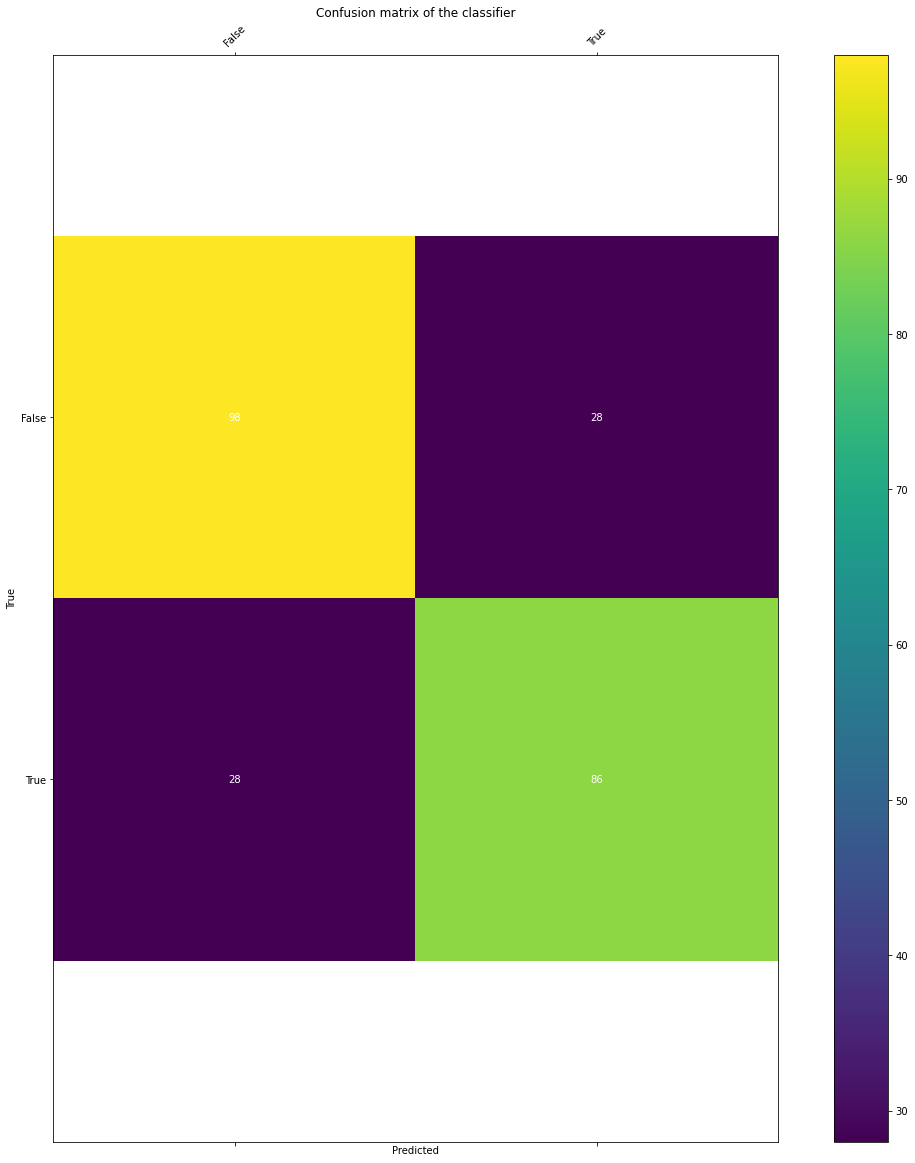


Classifier :Decision Tree
Training Accuracy 0.7741935483870968
Validation  Accuracy 0.7958333333333333
              precision    recall  f1-score   support

       False       0.85      0.74      0.79       126
        True       0.75      0.86      0.80       114

    accuracy                           0.80       240
   macro avg       0.80      0.80      0.80       240
weighted avg       0.80      0.80      0.80       240

(0.8006513061138736, 0.7988721804511278, 0.7957446808510639, None)


/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[False, True] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


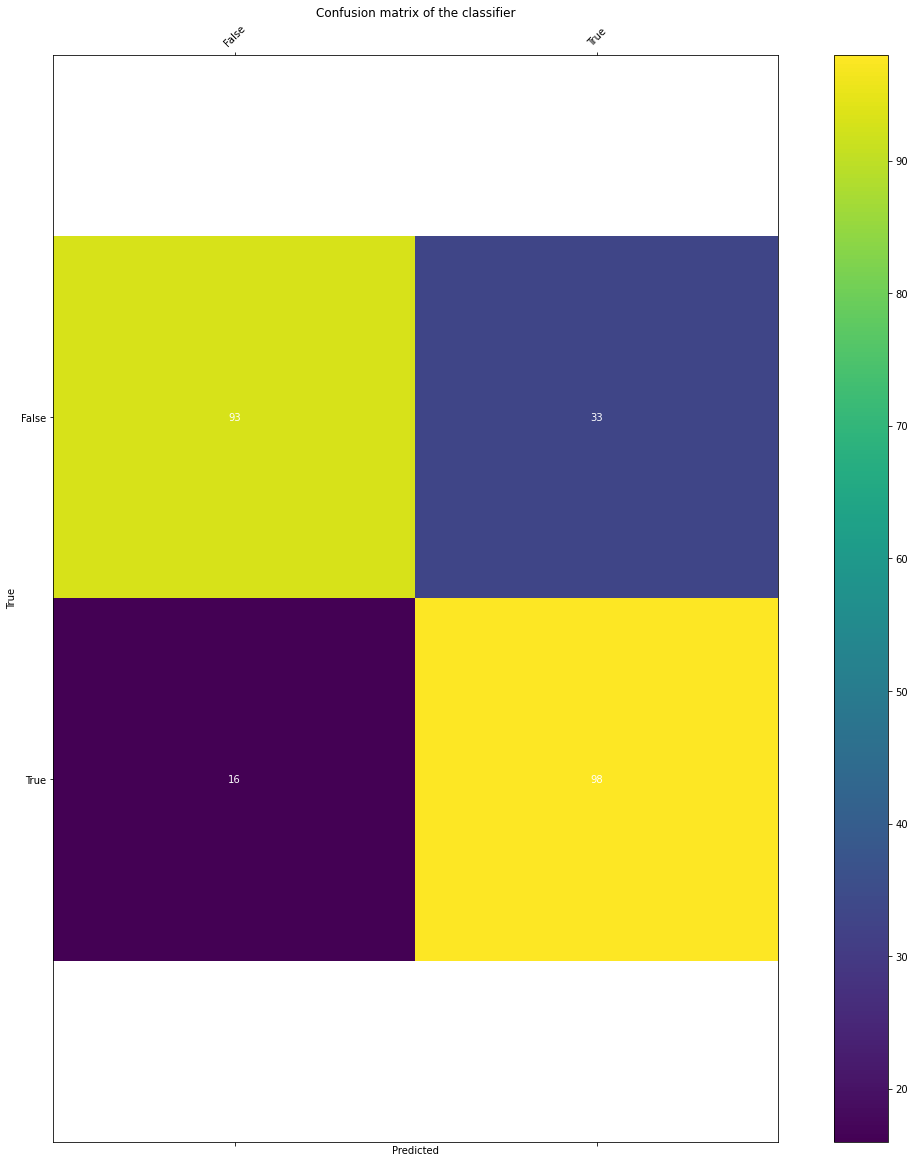


Classifier :Random Forest
Training Accuracy 1.0
Validation  Accuracy 0.775
              precision    recall  f1-score   support

       False       0.80      0.76      0.78       126
        True       0.75      0.79      0.77       114

    accuracy                           0.78       240
   macro avg       0.78      0.78      0.77       240
weighted avg       0.78      0.78      0.78       240

(0.775, 0.7756892230576441, 0.774859287054409, None)


/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[False, True] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


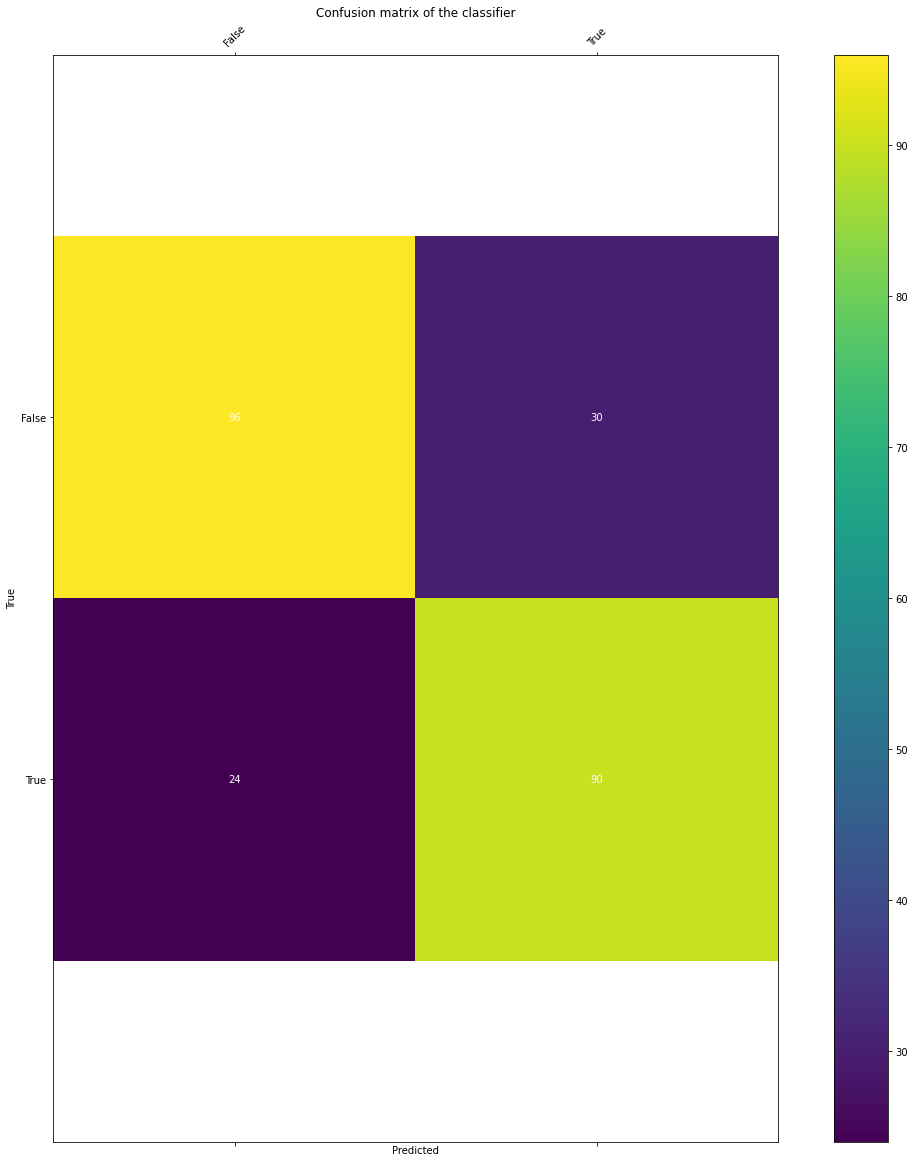


Classifier :SVM
Training Accuracy 1.0
Validation  Accuracy 0.8583333333333333
              precision    recall  f1-score   support

       False       0.88      0.85      0.86       126
        True       0.84      0.87      0.85       114

    accuracy                           0.86       240
   macro avg       0.86      0.86      0.86       240
weighted avg       0.86      0.86      0.86       240

(0.8580161155876632, 0.858813700918964, 0.8581757508342602, None)


/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[False, True] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


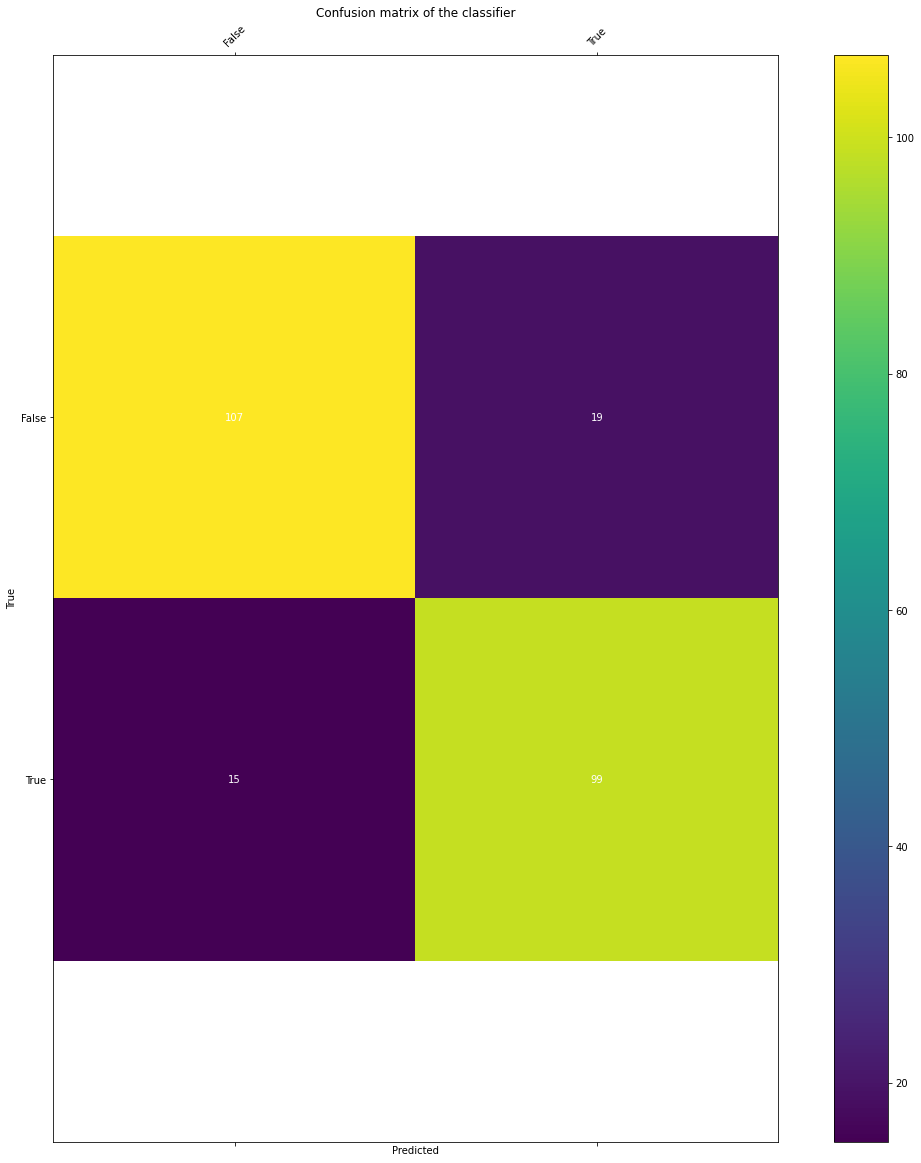


Classifier :KNN
Training Accuracy 0.8136200716845878
Validation  Accuracy 0.7875
              precision    recall  f1-score   support

       False       0.84      0.74      0.78       126
        True       0.74      0.84      0.79       114

    accuracy                           0.79       240
   macro avg       0.79      0.79      0.79       240
weighted avg       0.79      0.79      0.79       240

(0.7910119421747328, 0.7901002506265664, 0.787466791686201, None)


/Users/urmithakkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass labels=[False, True] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


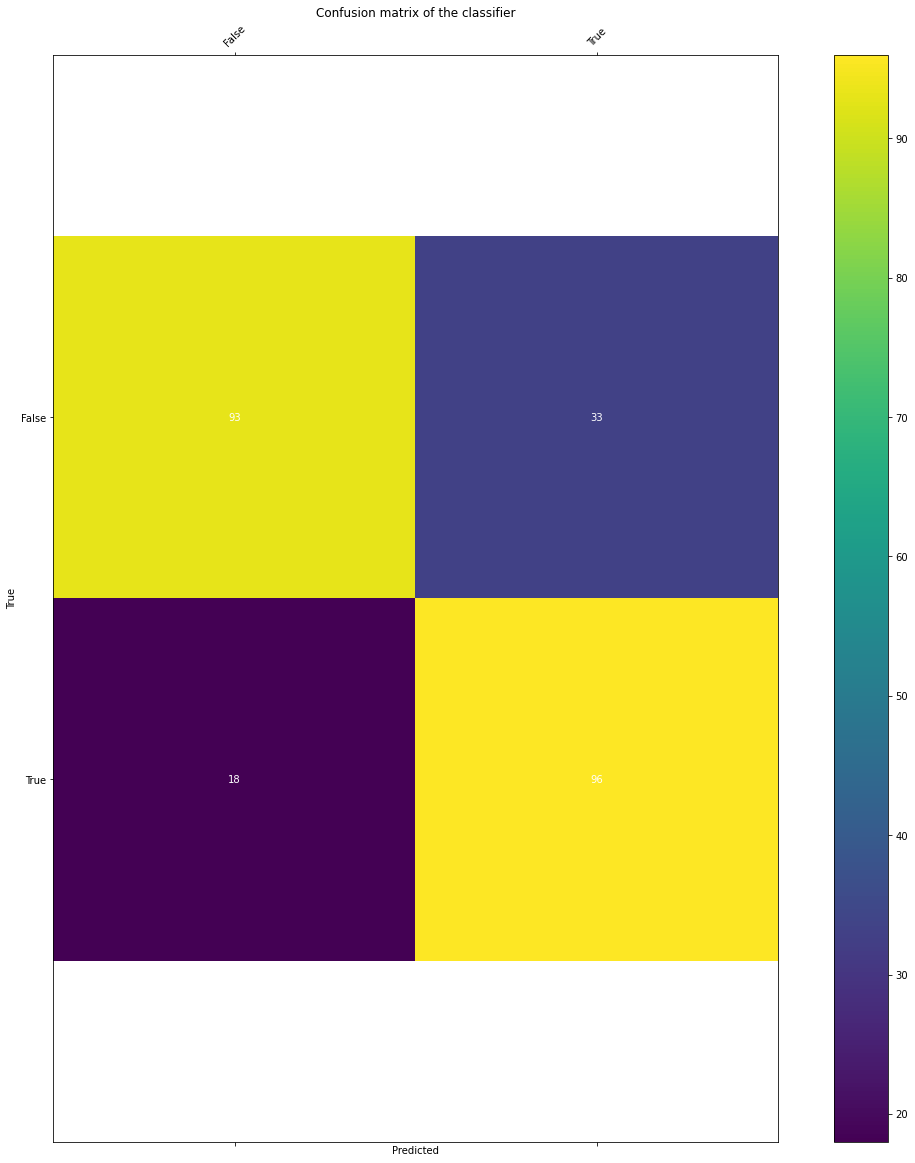





Classifier with best accuracy:SVM

Best accuracy:0.8583333333333333


In [238]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


for i,model in enumerate(pipelines):
    print("\nClassifier :{}".format(pipe_dict[i]))
    
    yt_p = model.predict(X_train)
    yv_p = model.predict(X_val)

    print('Training Accuracy', np.mean(yt_p==y_train))
    print('Validation  Accuracy', np.mean(yv_p==y_val))
    #print('The support vectors are', model.support_vectors_.shape)
    
    print(classification_report(y_val, yv_p))
    print(precision_recall_fscore_support(y_val, yv_p, average='macro'))  # print out accurate macro score
    confusion_matrix_heatmap(y_val, yv_p)
    
    if model.score(X_val,y_val)>best_accuracy:
        best_accuracy = model.score(X_val,y_val)
        best_pipeline = model
        best_classifier = i
print("\nClassifier with best accuracy:{}".format(pipe_dict[best_classifier]))
print("\nBest accuracy:{}".format(best_accuracy))

# 7 Dataset

**Describe the dataset that you will use to create your models and validate them. If you need to preprocess it, do it here. Include visualisations too. You can visualise raw data samples or extracted features.**

We have used the dataset of two songs (Potter and StarWars) comprising of hums and whistles making it a total of approx. 800 audio samples. 

Several levels of preprocessing was done in order to get the data ready to train the models.The samples with irrelevant song names and incorrect file names were deleted. All these steps were carried out as part of data cleaning and data pre processing. Then we performed feature engineering on the audio data.

In [242]:
sample_path = '/Users/urmithakkar/Desktop/MLAdvanceSolution/All/*.wav'
files = glob.glob(sample_path)

We can create a table-like structure using Python lists that collects the information that we can extract from the names of the audio files:

In [246]:
#Cleaning the dataset. Identifying the correctly named files and adding them into a list.

MLENDHW_table = [] 

for file in files:
    if len(file.split('/')[-1].split('_')) == 4:
        file_path = file
        file_name = file.split('/')[-1]
        participant_ID = file.split('/')[-1].split('_')[0]
        interpretation_type = file.split('/')[-1].split('_')[1]
        interpretation_number = file.split('/')[-1].split('_')[2]
        song = file.split('/')[-1].split('_')[3].split('.')[0]
        MLENDHW_table.append([file_name,participant_ID,interpretation_type,interpretation_number, song, file_path])
    else:
        continue

#print(MLENDHW_table)

In [ ]:
pd.set_option('display.max_rows', None)
MLENDHW_df = pd.DataFrame(MLENDHW_table,columns=['file_id','participant','interpretation','number','song', 'file_path']).set_index('file_id') 
MLENDHW_df



In [244]:
#Cleaning the data: Renaming the incorrect song names in the dataset


listStarWars = ['StarWars','[STARWARS]', 'starwar', 'Star wars','(starwars)' , 'star wars','[StarWars]','[StarWars] ','Starwars']
listPotter = ['Potter','[Potter]', 'potter', '[potter]', 'harry potter', '(potter)']
for song in range(0,len(MLENDHW_df['song'])):
    if MLENDHW_df.iloc[song,:]['song'] in listStarWars:
        MLENDHW_df.iloc[song,:]['song'] = listStarWars[0]
        continue
    if MLENDHW_df.iloc[song,:]['song'] in listPotter:
        MLENDHW_df.iloc[song,:]['song'] = listPotter[0]
        continue
    else:
        MLENDHW_df.drop(MLENDHW_df.index[song], axis = 0)
MLENDHW_df

participant interpretation    number  \
file_id                                                                
S216_hum_3_StarWars.wav                S216            hum         3   
S54_hum_2_Potter.wav                    S54            hum         2   
S135_hum_2_Potter.wav                  S135            hum         2   
S23_hum_3_StarWars.wav                  S23            hum         3   
S86_hum_4_StarWars.wav                  S86            hum         4   
S36_hum_1_Potter.wav                    S36            hum         1   
S157_hum_1_Potter.wav                  S157            hum         1   
S169_hum_1_Potter.wav                  S169            hum         1   
S216_hum_4_StarWars.wav                S216            hum         4   
S194_hum_1_[STARWARS].wav              S194            hum         1   
S77_whistle_2_Potter.wav                S77        whistle         2   
S23_hum_4_StarWars.wav                  S23            hum         4   
S86_hum_3_StarWars.wav                  S86            hum         3   
S137_hum_4_StarWars.wav                S137            hum         4   
S53_hum_1_Potter.wav                    S53            hum         1   
S131_hum_1_[Potter].wav                S131            hum         1   
S178_hum_2_[StarWars] .wav             S178            hum         2   
S192_hum_3_StarWars.wav                S192            hum         3   
S188_hum_2_Potter.wav                  S188            hum         2   
S165_whistle_2_StarWars.wav            S165        whistle         2   
S137_hum_3_StarWars.wav                S137            hum         3   
S192_hum_4_StarWars.wav                S192            hum         4   
S31_hum_2_Potter.wav                    S31            hum         2   
S194_hum_1_[Potter].wav                S194            hum         1   
S150_hum_2_Potter.wav                  S150            hum         2   
S35_hum_1_[Potter].wav                  S35            hum         1   
S126_whistle_2_Potter.wav              S126        whistle         2   
S154_whistle_2_StarWars.wav            S154        whistle         2   
S72_whistle_2_Potter.wav                S72        whistle         2   
S197_hum_2_Potter.wav                  S197            hum         2   
S206_hum_4_StarWars.wav                S206            hum         4   
S195_whistle_2_StarWars.wav            S195        whistle         2   
S200_whistle_2_StarWars.wav            S200        whistle         2   
S171_hum_2_Potter.wav                  S171            hum         2   
S209_whistle_2_Potter.wav              S209        whistle         2   
S206_hum_3_StarWars.wav                S206            hum         3   
S167_hum_2_StarWars.wav                S167            hum         2   
S94_hum_1_Potter.wav                    S94            hum         1   
S167_whistle_2_Potter.wav              S167        whistle         2   
S149_hum_4_StarWars.wav                S149            hum         4   
S148_hum_1_Potter.wav                  S148            hum         1   
S17_hum_1_Potter.wav                    S17            hum         1   
S127_hum_3_StarWars.wav                S127            hum         3   
S210_hum_2_Potter.wav                  S210            hum         2   
S149_hum_3_StarWars.wav                S149            hum         3   
S50_whistle_2_StarWars.wav              S50        whistle         2   
S93_hum_2_Potter.wav                    S93            hum         2   
S127_hum_4_StarWars.wav                S127            hum         4   
S91_whistle_2_Starwars.wav              S91        whistle         2   
S130_whistle_1_StarWars.wav.wav        S130        whistle         1   
S114_hum_2_potter.wav                  S114            hum         2   
S75_hum_2_Potter.wav                    S75            hum         2   
S45_whistle_2_Potter.wav                S45        whistle         2   
S168_whistle_2_Potter.wav              S168        whistle         2   


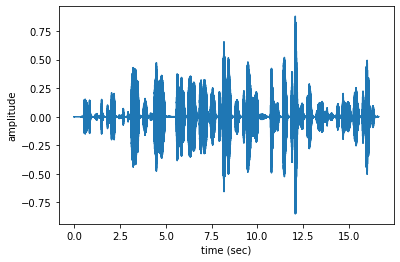

In [245]:
"""X is the signal which is a one dimensional numpy array containing values equal to sample_rate * duration of the song.
fs is the sample rate"""

n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
#print(files[n])
t = np.arange(len(x))/fs
#print(t)
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

# 8 Results

**Carry out your experiments here, explain your results.**

Each machine learning algorithm was compared to the others in terms of how well suited they were to the problem of Audio Classification.

**Random Forest Classifier**
On using Random Forest Classifier to classify the data into its classes,we obtained a training accuracy of 1.0 and a validation accuracy of 0.8625 with an F-1 score of 0.86. Here we can clearly see that there is an overfitting on the training data. 
Then, we performed hyperparameter tuning on it by chnaging the n_estimators to 200,300 and 400 but there were slight increases in the validation accuracies and the F-1 scores. However, the overfitting on the trainind data was seen in every instance. Therefore, the model was rejected.

**Logistic Regression**
On using Logistic Regression to classify the data into the two classes, we obtained a training accuracy of 0.77 and a validation accuracy of 0.795. The F-1 score was 0.795. On experimenting further and changing the values of hyperparameter to 2.0 and 3.0, no changes were observed whatsoever. 
The results obtained by using Logistic Regression were positive as the accuracy increased on the validation data.


**Support-Vector Machine:**
On using Support Vector Machine with C = 1 to classify the data into its classes, a training accuracy of 0.81 and a validation accuracy of 0.78 and an F1- score of 0.78. On increasing the calue of C and adding the kernel = linear parameter, it was observed that the validation accuracy increased slightly and training accuracy increased to 1.0, which is overfitting, therefore, the model was over fitting the data. On using kernel = 'rbf' the validation accuracy decreased but training accuracy remained 1.0. We can conclude that the model is overfitting the data.


**KNN**
KNN is observed to be the most effective model with a training accuracy of 0.813 and validation accuracy of 0.787. Looking at the confusion matrix 78% of the samples are predicted correctly. 

# 9 Conclusions

Your conclusions, improvements, etc should go here

The task included comparing machine learning algorithms as to how well they suited to the problem to Audio Classification using the MLEnd Hums and Whistles dataset. Classification was based on several features extracted from each audio segment of the dataset. Analysis of accuracies and F-scores indicated that some of the features were more significant than the others.

**In conclusion, KNearestNeighbours proved to the best model as compared to the other models.**

Several features were added and removed and experiments were carried out. However,for  future improvements, several other features could be added and experimented with. Complex feature modifications in this model can also be carried out to obtain better results. Another way can be using other models and analysing the classification reports and confusion matrices.

